# Modeling

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import time
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## Importing Data

In [3]:
pos = pd.read_csv('./data/possitive_case.csv')
neg = pd.read_csv('./data/negative_case.csv')

### Removing Unnecessary Columns

In [4]:
neg_columns = ['Unnamed: 0','marketplace','star_rating','helpful_votes','total_votes','verified_purchase','review_headline','review_date','product_title']

In [63]:
neg_reviews_df = neg.drop(columns=neg_columns)
neg_reviews_df = neg_reviews_df.dropna()

### Adding Status column to positive class

In [6]:
pos['Status'] = 1

In [64]:
pos_reviews_df = pos.drop(columns=neg_columns)
pos_reviews_df = pos_reviews_df.dropna()

### Joining the review dataset

In [8]:
join = [pos_reviews_df,neg_reviews_df]

In [9]:
joined = pd.concat(join)

In [10]:
len(joined)

311311

In [11]:
joined = joined.dropna()

In [12]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311303 entries, 0 to 157550
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_body  311303 non-null  object
 1   Status       311303 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.1+ MB


In [13]:
joined.head()

,review_body,Status
0,"Easy read, second part to the book If I Stay. ...",1
1,Husband loved it!,1
2,A friend recommended this and I'll pass to you...,1
3,Very good item. Quick delivery.,1
4,Enjoyed this book. Looking forward to a seque...,1


### Looking at the data distrbution

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

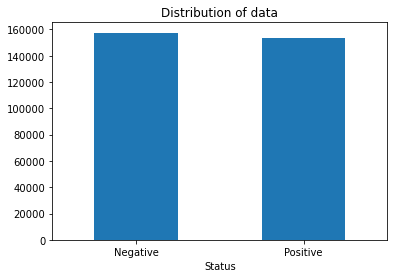

In [14]:
ax = joined.groupby('Status').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)


### Seperating the columns into list

In [65]:
text, status = list(joined['review_body']), list(joined['Status'])
text_neg,status_neg = list(neg_reviews_df['review_body']),list(neg_reviews_df['Status'])
text_pos,status_pos = list(pos_reviews_df['review_body']),list(pos_reviews_df['Status'])


## Data Cleaning

### Creating a function to remove emojis, remove stop words and Lemmatize the text

In [70]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

Url_Pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
User_Pattern = '@[^\s]+'
Alph_Num_Pattern = "[^a-zA-Z0-9]"
Repeat_Pattern = r"(.)\1\1+"
Replace_Pattern = r"\1\1"

stop_word_list = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'book', 'story', 'one',
            'read','book ', 'great','reading','little','make','year','many',
            'way','want','author','serie','page','much','well','look','seem','word','make',
            'tell','really','first','even','work',' book','might','made','give','full',
            'type',' character','page','characters','written','recommended','reader',
            'writting', 'stories','people','better','always','enough','everyone','thing','people'
            'recommended','something','recommends','another','highly','though','anyone','writing',
            'writtings','chapter','interesting','wonderful','excellent']


def process_words(text):
    processed_text = []
    wordLemm = WordNetLemmatizer()
    for review in text:
        review = re.sub(Alph_Num_Pattern, ' ', review)
        review = review.lower()
        review = re.sub(Url_Pattern, 'Url', review)
        for emoji in emojis.keys():
            review = review.replace(emoji, emojis[emoji])
        review = re.sub(User_Pattern, 'User', review)
        review = re.sub(Repeat_Pattern, Replace_Pattern, review)
        review_words = ''
        for word in review.split():
                if word not in stop_word_list:
                    if word != 'USER':
                        if word != 'URL':
                            if len(word)>5:
                                word = wordLemm.lemmatize(word)
                                review_words += (word+' ')
                
        processed_text.append(review_words)
    return processed_text
    

In [71]:
t = time.time()
processedtext = process_words(text)
neg_processed_text = process_words(text_neg)
pos_processed_text = process_words(text_pos)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 173 seconds


### Making a word cloud of the cleaned text

Time Taken: 22 seconds


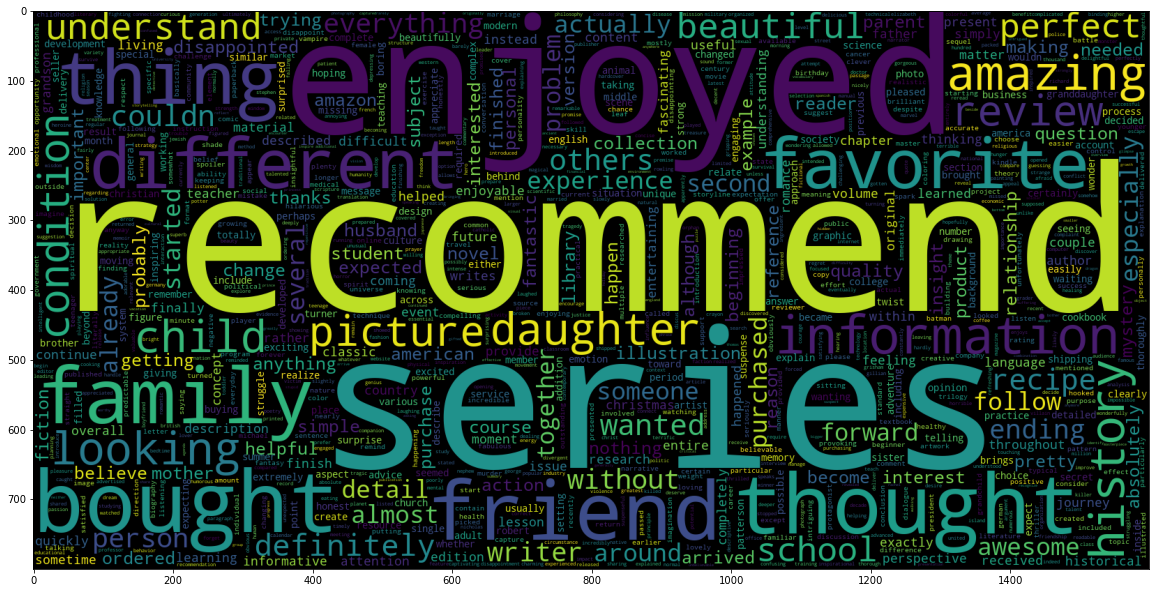

In [72]:
t = time.time()
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(processedtext))
plt.imshow(wc)
print(f'Time Taken: {round(time.time()-t)} seconds')

Time Taken: 19 seconds


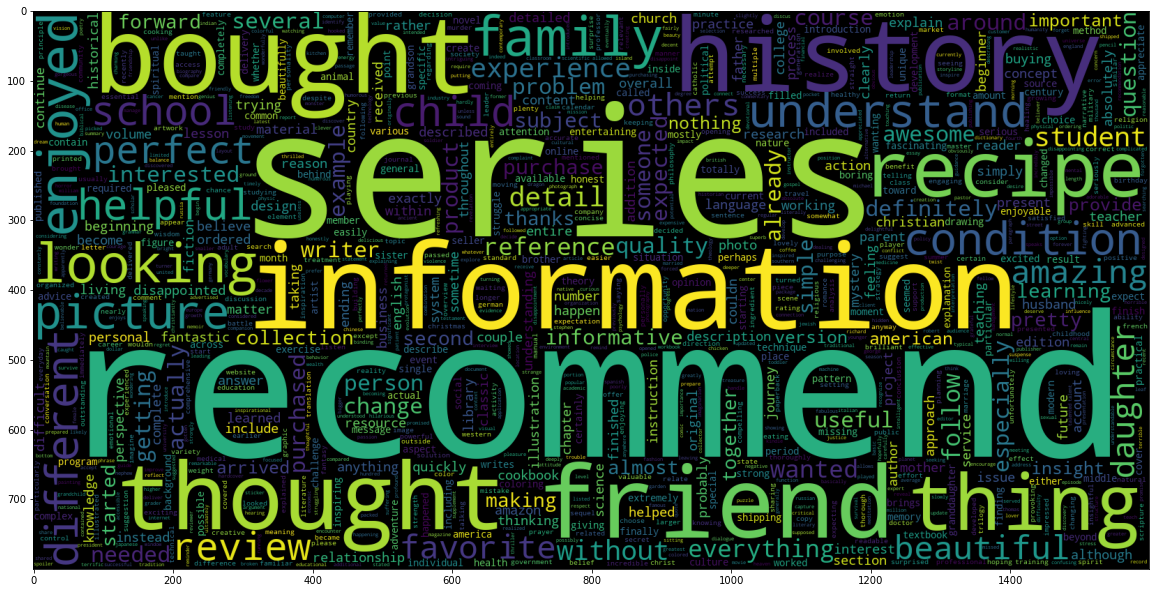

In [73]:
t = time.time()
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neg_processed_text))
plt.imshow(wc)
print(f'Time Taken: {round(time.time()-t)} seconds')

Time Taken: 20 seconds


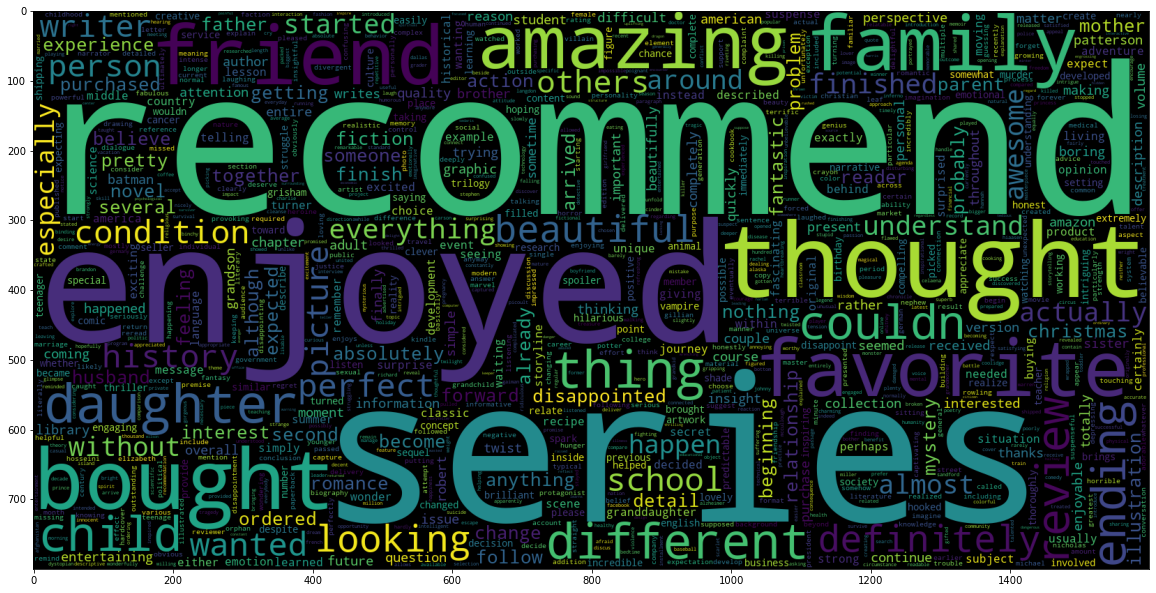

In [74]:
t = time.time()
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(pos_processed_text))
plt.imshow(wc)
print(f'Time Taken: {round(time.time()-t)} seconds')

## Creating Models

### Splitting the data

In [77]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, status,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [78]:
len(X_train)


249042

### Using TFIDF vectorizer to transform the data

In [79]:
vectoriser = TfidfVectorizer(ngram_range=(2,3), max_features=400000)
X_train = vectoriser.fit_transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  400000


### Creating a function to evaluate different models

In [26]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#### Bernoulli

              precision    recall  f1-score   support

           0       0.69      0.80      0.74     31484
           1       0.76      0.62      0.68     30777

    accuracy                           0.71     62261
   macro avg       0.72      0.71      0.71     62261
weighted avg       0.72      0.71      0.71     62261



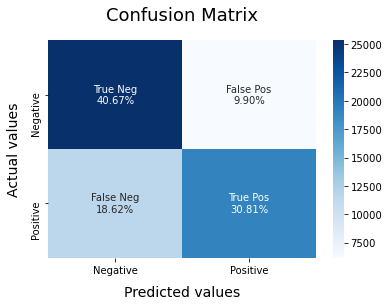

In [27]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

Not a bad Baseline model, classifies well but is lacking in the possitive class 

#### Linear SVC

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     31484
           1       0.73      0.75      0.74     30777

    accuracy                           0.74     62261
   macro avg       0.74      0.74      0.74     62261
weighted avg       0.74      0.74      0.74     62261



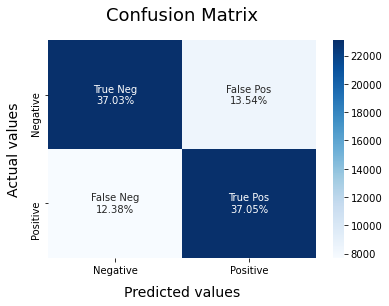

In [28]:
LineSVCmodel = LinearSVC()
LineSVCmodel.fit(X_train, y_train)
model_Evaluate(LineSVCmodel)

Much more even distribution and a higher accuracy score, promissing model to dive further into

#### Logistic

              precision    recall  f1-score   support

           0       0.76      0.73      0.75     31484
           1       0.74      0.76      0.75     30777

    accuracy                           0.75     62261
   macro avg       0.75      0.75      0.75     62261
weighted avg       0.75      0.75      0.75     62261



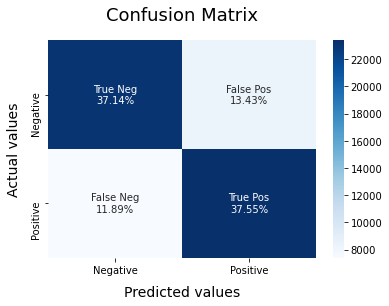

In [29]:
LogModel = LogisticRegression(max_iter=400)
LogModel.fit(X_train, y_train)
model_Evaluate(LogModel)

The best and more even model so far, the model I'll focus on going forward

#### SVC

/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.50      0.66      0.57     31484
           1       0.49      0.33      0.39     30777

    accuracy                           0.50     62261
   macro avg       0.49      0.49      0.48     62261
weighted avg       0.49      0.50      0.48     62261



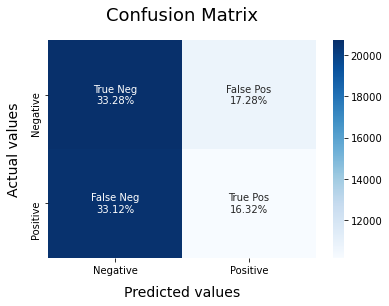

In [82]:
SVCModel = SVC(max_iter=500)
SVCModel.fit(X_train, y_train)
model_Evaluate(SVCModel)

The worst model, expremely high recall, most likely due to classifying everything as one class